In [1]:
import os
import sys
import csv

module_path = os.path.abspath(os.path.join('..'))
module_path2 = os.path.abspath(os.path.join('../../AxolotlDataScience'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
if module_path2 not in sys.path:
    sys.path.append(module_path2)

from DataManipulation import DataManipulation as axolotlManipulation
from DataVisualization import TypeOfAccessBarChart
from DataPrediction import MLHandler
from DataPrediction import CartolaProML
from Graphics import MultipleColumnsBarChartByClass
from Graphics import SingleColumnBarChartByClass
from MachineLearning.Classifiers import ClassifierFactory
from MachineLearning.Classifiers import ClassifierTypes
from Validation import NFoldCrossValidation as validator
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_frame = pd.read_csv('../input_data/ge_mes_olimpiadas.csv', sep=',')

Churn e Recomendações
----------------------


Na base de dados do globo esporte temos 3 tipos de assinaturas, os que possuem conta no cartola, os que possuem o catola pro, e finalmente os assinantes da globo.com. Para tais usuários é importante saber se eles pretendem sair, e para os não assinantes, é importante indentificar os possíveis assinantes para axiliar o time de marketing em sua tomada de decisão.

Para a identificação de churn e recomendação de assinatura iremos utilizar métodos de classificação, e trabalhar em cima dos falso positivos e falso negativos, ou seja:

* Falso positivo: Se um usuário é classificado como assinante, porém ele não possui assinatura, ele é um caso de possível assinante, pois apesar de não possuir assinatura possui o mesmo comportamento que os que a tem.

* Falso negativo: Se um usuário é classificado como não-assinante, porém ele é um assinante, ele é um caso de churn, pois está cada vez mais se comportando como não assinante.


### Cartola

Apesar de não ser uma assinatura paga, o cartola pode gerar interesse nos usuários de ter uma conta cartola-pro, sendo assim é interessante captar e manter os usuários do cartola, por este motivo também iremos analisar essa classe de assinantes.

O cartola é sobre futebol nacional, sendo assim supõe-se que quem possui uma conta cartola se interessa por futebol, como não podemos afirmar o mesmo sobre as outras modalidades iremos retira-las do dataset para realizar este experimento, referente ao cartola e cartola-pro.

#### Manipulação dos dados

Nós possuimos algumas informações socio-demográficas dos usuários, e também o tempo/frequência com que ele acessou o globo esporte e também temos os tempos que eles gastaram em relação a cada assunto.

Temos que entender que temos vários tipos de usuários, principalmente em relação ao tempo gasto no globo esporte, por exemplo, um usuário que utiliza o globo esporte por 600 horas por mês, e dessas 600 horas fica 100 horas vendo sobre futebol possui menos interesse no assunto que um usuário que utiliza o globo esporte por 100 horas e dessas 100 horas, 75 horas são sobre futebol.

Desta forma irei utilizar não o valor bruto de horas, porém o relativo por usuário, no caso do exemplo citado acima, o primeiro usuário ficaria com 0.16 em futebol, enquanto o segundo ficaria com 0.75. 

Além disso, para auxiliar alguns classificadores eu "normalizo" estes valores pela média, de modo que o usuário que acessou na média fica com o valor de 1, quem acessou abaixo da média fica com < 1 e acima da média com > 1.

Quanto aos campos de frequencia de acesso e tempo total eu os discretizo por um número n de grupos, também com o intuito de auxiliar os algoritmos de classificação.

In [2]:
cartola_df = data_frame.copy()

axolotl_manipulation = axolotlManipulation.DataManipulation(cartola_df)

to_remove_columns = ["home_notic_olimp", "ginastica", "basquete", "volei", "handebol", "tenis", "atletismo", "natacao", "judo",
                     "saltos_orn", "canoagem", "home", "tipo", "user", "dias_desktop", "pviews_desktop", "visitas_desktop", "dias_mobile", "pviews_mobile",
                     "visitas_mobile", 'tempo_total_desktop', 'tempo_total_mobile', "cartola_pro"]

age_range = [-np.inf, 0.1, 13, 23, 35, 48, np.inf]
dias_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('dias', 5)
pviews_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('pviews', 10)
visitas_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('visitas', 10)
tempo_total_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('tempo_total', 10)

cartola_df = axolotl_manipulation.drop_columns(to_remove_columns) \
                                 .set_categorical_columns(['sexo', 'uf']) \
                                 .divide_by_column(['fut_int', 'futebol', 'fut_olimp', 'blog_cartola'], 'tempo_total') \
                                 .normalize_columns(['fut_int_by_tempo_total', 'futebol_by_tempo_total', 'fut_olimp_by_tempo_total', 'blog_cartola_by_tempo_total'])\
                                 .discretize_column('idade', age_range) \
                                 .discretize_column('dias', dias_range) \
                                 .discretize_column('pviews', pviews_range) \
                                 .discretize_column('visitas', visitas_range) \
                                 .discretize_column('tempo_total', tempo_total_range)

cartola_df = axolotl_manipulation.get_data_frame()
cartola_df['cartola'].fillna(0)
cartola_df['idade'].fillna(0, inplace=True)

#### Treinamento

Uma vez com os dados pré-processados iremos tentar aprender algo com eles, neste caso a dizer se um usuário é assinante cartola ou não, para isto usaremos algoritimos de classificação.

Tendo este classificador o nosso maior interesse neste caso não é que ele preveja em outra base de dados os usuários cartola, mas sim que na mesma base ele nos indique quem os casos de churn e possíveis assinantes, como expliado acima iremos utilizar o conceito de false-positivo e falso-negativo para isto.

Porém atribuir tal tarefa a apenas 1 algoritmo de ML seria confiar muito no mesmo, afinal, um algoritmo a pode ter acurácia maior que um algoitmo b no todo, porém quando comparado apenas os casos de assinantes, o b pode superar o a em acurácia, ou seja o algoritmo b tem menos casos de falso negativo, porém tem uma ocorrência maior de falso positivo, logo utilizar vários algoritmos nos dá uma análise mais certa.

Deste modo aderi a uma abordagem de unanimidade, onde eu só falarei se um elemento é falso positivo ou falso negativo se ele o for em todos os classificadores.

Afinal, se um grupo de 

Os algoritmos que serão executados são: **Árvore Binária, KNN, NaiveBayes e Redes Neurais**, todos utilizados a partir da biblioteca sklearn. Estes foram o que apresentaram maior acurácia dentre os que testei.

In [3]:
attributes = cartola_df.loc[:, cartola_df.columns != 'cartola']
classes = cartola_df["cartola"]

total_custumers_len = len(cartola_df[cartola_df["cartola"] == 1])
total_not_custumers_len = len(cartola_df[cartola_df["cartola"] == 0])

classifier_types = ClassifierTypes.ClassifierTypes
ml_algorithms = [classifier_types.Tree, classifier_types.KNN, classifier_types.NaiveBayes, classifier_types.NeuralNetwork]

ml_handler = MLHandler.MLHandler(attributes, classes)

train_ml_algorithms = ml_handler.train_data_in_mls_algorithms(ml_algorithms)\
                                .calc_accuracy_of_mls_algorithms()\
                                .calc_prediction_classes_of_mls_algorithms()\
                                .calc_false_negatives_and_positives(data_frame['user'])

accuracy_ml_algorithms = train_ml_algorithms.get_accuracy()
false_positives_and_negatives = train_ml_algorithms.get_false_positives_dict()

print(accuracy_ml_algorithms)

print("FP: ", len(false_positives_and_negatives["FP"]), "/", total_not_custumers_len, " = ",
      len(false_positives_and_negatives["FP"]) / total_not_custumers_len,
      "\nFN: ", len(false_positives_and_negatives["FN"]), "/", total_custumers_len, " = ",
      len(false_positives_and_negatives["FN"]) / total_custumers_len)

output_df = pd.DataFrame.from_dict(false_positives_and_negatives,orient='index', dtype='str').transpose()
output_df.columns = ["Recomendations", "Churn"]

# Para gerar o csv descomentar linha abaixo
# output_df.to_csv('result.csv')

print(output_df.head())

[0.8732629309185761, 0.80115076550736275, 0.76562287589484423, 0.84443191905767512]
FP:  2742 / 15183  =  0.18059672001580715 
FN:  2427 / 24394  =  0.09949167828154465
  Recomendations    Churn
0        1937751  1987950
1        1982098  1988149
2        1987690  1996199
3        2062701  1997603
4        2070594  2028765


### Assinantes Globo.com

Aqui acontece algo interessante, como existem muito mais não assinantes que assinantes na base de dados os classificadores ficam "viciados" em dar a maior classe, visto que se ele simplesmente assinalar Não Assinante para todo mundo ele já está acertando mais de 90% dos casos, e é isto que ele faz. 

In [5]:
customers_df = data_frame.copy()
axolotl_manipulation = axolotlManipulation.DataManipulation(customers_df)

to_remove_columns = ["user", "dias_desktop", "pviews_desktop", "visitas_desktop", "dias_mobile", "pviews_mobile", "visitas_mobile", 'tempo_total_desktop', 'tempo_total_mobile']
olympic_columns = ["home_notic_olimp", "ginastica", "basquete", "volei", "handebol", "tenis", "atletismo", "natacao", "judo", "saltos_orn", "canoagem", 'fut_olimp']
soccer_related_columns = ['fut_int', 'futebol', 'fut_olimp']
homes_columns = ['home', 'home_notic_olimp']

data_frame['tipo'].fillna("NÃO ASSINANTE", inplace=True)
customers_df['tipo'].fillna("NÃO ASSINANTE", inplace=True)
customers_df['idade'].fillna(0, inplace=True)

customers_df['tipo'] = customers_df['tipo'].replace(['NÃO ASSINANTE'], 0)
customers_df['tipo'] = customers_df['tipo'].replace(['ASSINANTE'], 1)

age_range = [-np.inf, 0.1, 13, 23, 35, 48, np.inf]
dias_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('dias', 5)
visitas_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('visitas', 10)
pviews_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('pviews', 10)
tempo_total_range = axolotl_manipulation.get_discretization_intervals_based_on_number_of_groups('tempo_total', 10)

# create_new_column_based_on_operation => Protótipo, atualmente somente faz soma, a ideia é passar a operação
axolotl_manipulation = axolotl_manipulation.drop_columns(to_remove_columns) \
                                           .set_categorical_columns(['sexo', 'uf', 'tipo']) \
                                           .create_new_column_based_on_operation(olympic_columns, "olympic_columns", drop_after_merge=False)\
                                           .create_new_column_based_on_operation(soccer_related_columns, "soccer_related_columns", drop_after_merge=False)\
                                           .create_new_column_based_on_operation(homes_columns, "homes_columns", drop_after_merge=False)\
                                           .drop_columns(set(soccer_related_columns + homes_columns + olympic_columns)) \
                                           .divide_by_column(['olympic_columns', 'soccer_related_columns', 'homes_columns', 'blog_cartola'], 'tempo_total') \
                                           .normalize_columns(['blog_cartola_by_tempo_total', 'olympic_columns_by_tempo_total', 'soccer_related_columns_by_tempo_total', 'homes_columns_by_tempo_total'])\
                                           .discretize_column('idade', age_range) \
                                           .discretize_column('dias', dias_range) \
                                           .discretize_column('pviews', pviews_range) \
                                           .discretize_column('visitas', visitas_range) \
                                           .discretize_column('tempo_total', tempo_total_range)

customers_df = axolotl_manipulation.get_data_frame()

Como este não é o caso aqui nós precisamos recorrer a algumas técnicas para balancear a base de dados, como a classe dos Não Assinantes é muito maior que a classe dos Assinantes, se a gente optar por oversampling nós estaremos nos submetendo a um muito provável overfitting, sendo assim, optei por escolher uma média dou um underfitting nos não assinantes, e depois dou um leve overfitting nos Assinantes.

Temos 1133 assinantes, eu faço 3 conjuntos de 400 pra pegar 1200, sem necessariamente utilizar todos, pra amenizar o overfitting, depois eu uso um desses conjuntos 2x, pra ser o oversampling.

In [6]:
print(customers_df.tipo.value_counts())

df_custumer_partial_1 = customers_df[customers_df["tipo"] == 1].sample(400)
df_custumer_partial_2 = customers_df[customers_df["tipo"] == 1].sample(400)
df_custumer_partial_3 = customers_df[customers_df["tipo"] == 1].sample(400)
df_not_custumer_partial = customers_df[customers_df["tipo"] == 0].sample(400*4)

df_new = pd.concat([df_custumer_partial_1, df_custumer_partial_2, df_custumer_partial_3, df_custumer_partial_1, df_not_custumer_partial])

print(df_new.tipo.value_counts())

0    38444
1     1133
Name: tipo, dtype: int64
1    1600
0    1600
Name: tipo, dtype: int64


Agora nós temos uma base equilibrada, porém com perda de informação, a nossa próxima escolha agora é quanto a escolha dos algoritmos, até então venho sempre usando 4 algoritmos e fazendo votação para perceber os falso positivos e negativos, porém agora temos uma escolha a ser feita.

O overfitting no KNN escala muito rápido, devido a ele utilizar os vizinhos mais próximos, se temos tuplas repetidas ele vai acabar dando overfitting mais rápido, porém isto não é tão evidente nos outros algoritmos. Nos outros algoritmos podemos notar uma melhor acurácia em relação aos não assinantes, mas ao fazer a votação a taxa de churn "aumenta" em 6%, porém não podemos confiar que estes 6% realmente tem menos chances de sair, ou somente foram casos de overfitting.

Portanto seguiremos o mesmo padrão anterior, onde somente consideraremos falsos positivos/negativos os que forem votados pela maioria dos classificadores erroneamente, deste modo iremos reduzir a questão da memorização do KNN.

Outro ponto a se utilizar é a alta relação que se tem entre a assinatura e o uso do cartola_pro.

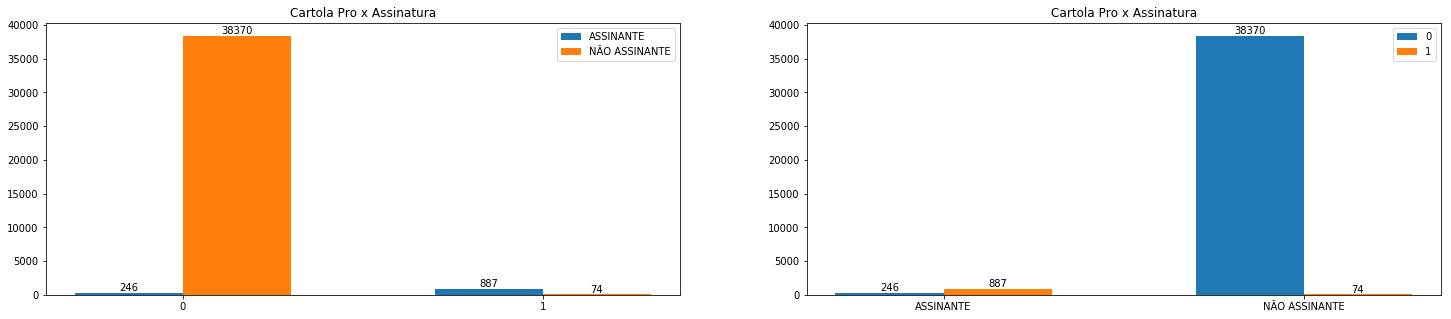

In [7]:
bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=2, x_size=25, y_size=5)

bar_chart.set_attribute_values(data_frame.cartola_pro) \
         .set_class_values(data_frame.tipo) \
         .plot_chart('Cartola Pro x Assinatura', 0, 0)
        
bar_chart.set_attribute_values(data_frame.tipo) \
         .set_class_values(data_frame.cartola_pro) \
         .plot_chart('Cartola Pro x Assinatura', 0, 1)        

In [10]:
classifier_types = ClassifierTypes.ClassifierTypes

attributes = df_new.loc[:, df_new.columns != 'tipo']
classes = df_new["tipo"]
total_attributes = customers_df.loc[:, customers_df.columns != 'tipo']
total_classes = customers_df["tipo"]
total_custumers_len = len(customers_df[customers_df["tipo"] == 1])
total_not_custumers_len = len(customers_df[customers_df["tipo"] == 0])

ml_algorithms = [classifier_types.Tree, classifier_types.KNN, classifier_types.NaiveBayes, classifier_types.NeuralNetwork]
ml_handler = MLHandler.MLHandler(attributes, classes)

train_ml_algorithms = ml_handler.train_data_in_mls_algorithms(ml_algorithms)\
                                .calc_accuracy_of_mls_algorithms(attributes= total_attributes, classes=total_classes)\
                                .calc_prediction_classes_of_mls_algorithms(attributes= total_attributes, classes=total_classes)\
                                .calc_false_negatives_and_positives(data_frame['user'], attributes=total_attributes, classes=total_classes)

accuracy_ml_algorithms = train_ml_algorithms.get_accuracy()
false_positives_and_negatives = train_ml_algorithms.get_false_positives_dict()

print(accuracy_ml_algorithms)

print("FP: ", len(false_positives_and_negatives["FP"]), "/", total_not_custumers_len, " = ",
      len(false_positives_and_negatives["FP"]) / total_not_custumers_len,
      "\nFN: ", len(false_positives_and_negatives["FN"]), "/", total_custumers_len, " = ",
      len(false_positives_and_negatives["FN"]) / total_custumers_len)

output_df = pd.DataFrame.from_dict(false_positives_and_negatives,orient='index', dtype='str').transpose()
output_df.columns = ["Recomendations", "Churn"]

# Para gerar o csv descomentar linha abaixo
# output_df.to_csv('result.csv')

print(output_df.head())

[0.98984190558924645, 0.97528851945966488, 0.95778349295127296, 0.98991766314888352]
FP:  2189 / 38444  =  0.05693996462386849 
FN:  192 / 1133  =  0.16946160635481025
  Recomendations     Churn
0        1979452  21558108
1        2061759  24444010
2        2062701  28768407
3        2557977  28806889
4        2667323  29137487


## Trabalhos Futuros

#### Cartola_pro

Infelizmente não tive tempo hábil pra explorar ele a fundo, a classificação do catola_pro teve um problema semelhante ao de usuários, pelo mesmo motivo, eu até iniciei o código dele, porém é necessário fazer o under/oversampling e realizar alguns testes.

#### UnderSampling

Eu utilizei um undersampling randomico, o que não é tão bom, principalmente quando há uma diferença tão grande entre as classes, o que eu pensei foi em utilizar o k means, criar 1600 clusters e pegar 1 exemplo de cada cluster, porém esta decisão implica em outra questão, 1600 exemplifica bem estes dados? Se eu precisar mais que isso, vou gerar muito overfitting com o oversampling?

Note que melhorando o undersampling teremos casos que representam um cluster, deste modo a quantidade de informação perdida será reduzida e o classificador se comportará melhor, o número de 17% pra churn é alto, e precisamos de um cuidado maior no undersampling pra resolver isso.

#### Dados utilizados

Os dados que eu utilizei foram de apenas 1 mês, durante esse projeto eu tentei identificar o perfil do usuário, de maneira sutil, nas horas em que pego o tempo relativo que ele fez cada coisa em relação ao tempo total utilizado.

Uma ideia que eu tive, foi analisar o crescimento mensal desse interesse, então poderiamos ver se este usuário está "criando" um novo interesse, por exemplo, se um usuário que normalmente passava 15% do tempo total vendo notícias sobre futebol, se no proximo mês ele tem 30%, mesmo podendo ser um valor baixo em relação aos demais, essa taxa de crescimento é significativa, e pode nos auxiliar a indicar uma conta do cartola_pro pra ele, por exemplo. O contrário pode nos auxiliar com o churn, caso o interesse esteja caindo.